In [23]:
from demo_backend.modeling import get_data_dict

In [11]:
from sklearn.feature_extraction import DictVectorizer
import pandas as pd

In [63]:
import rethinkdb as r
from demo_backend.models import db
import numpy as np
import pandas as pd

def get_data():
    conn = r.connect('localhost', '28015')
    cursor = db.table('township_village') \
        .pluck(['county', 'township', 'village', 'scores', 'average_income_per_capita']).run(conn)
    villages = []

    for item in cursor:
        incomes = []
        for income in item['average_income_per_capita']:
            data = {}
            data['avg_income'] = np.sum([
                income['distribution']['below_5k'] * 2500,
                income['distribution']['5k_10k'] * (5000 + 10000) / 2,
                income['distribution']['10k_15k'] * (10000 + 15000) / 2,
                income['distribution']['15k_20k'] * (15000 + 20000) / 2,
                income['distribution']['20k_25k'] * (20000 + 25000) / 2,
                income['distribution']['above_25k'] * 25000,
            ])
            data['year'] = income['year']
            incomes.append(data)

        result = pd.merge(pd.DataFrame(incomes), pd.DataFrame(item['scores']), on='year')
        result['township'] = item['township']
        result['village'] = item['village']
        villages.append(result)

    conn.close()
    return pd.concat(villages)

In [64]:
data = get_data_dict()

In [262]:
feature_cols = [col for col in data.columns if col not in [u'overall']]
x = data[feature_cols].to_dict(orient='records')
y = data[u'overall'].values

In [263]:
vec = DictVectorizer()

In [264]:
features = vec.fit_transform(x)

In [89]:
from sklearn.linear_model import LinearRegression

In [92]:
model = LinearRegression()
model.fit(features, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [104]:
test_data = data[feature_cols].iloc[0].to_dict()

In [119]:
x_test = vec.transform(test_data)

In [120]:
model.predict(x_test)

array([ 32.73954238])

In [108]:
data['overall'].iloc[0]

29.301601294499999

In [150]:
from sklearn import cross_validation, metrics, preprocessing
from tensorflow.contrib import learn

In [265]:
x = features.toarray()
y = data[u'overall'].values

In [266]:
# Split dataset into train / test
x_train, x_test, y_train, y_test = cross_validation.train_test_split(x, y, test_size=0.2, random_state=42)

In [267]:
# Scale data (training set) to 0 mean and unit standard deviation.
scaler = preprocessing.StandardScaler()
x_train = scaler.fit_transform(x_train)

In [292]:
# Build 2 layer fully connected DNN with 10, 10 units respectively.
regressor = learn.DNNRegressor(hidden_units=[105, 50])

In [293]:
from __future__ import unicode_literals
# Fit
regressor.fit(x_train, y_train, steps=5000, batch_size=1)

# Predict and score
y_predicted = regressor.predict(scaler.transform(x_test))
score = metrics.mean_squared_error(y_test, y_predicted)

print('MSE: {0:f}'.format(score))


MSE: 0.110975


In [299]:
regressor.get_variable_names()

['centered_bias_weight',
 'centered_bias_weight/Adagrad',
 'dnn_logit/bias',
 'dnn_logit/bias/Adagrad',
 'dnn_logit/weights',
 'dnn_logit/weights/Adagrad',
 'global_step',
 'hiddenlayer_0/bias',
 'hiddenlayer_0/bias/Adagrad',
 'hiddenlayer_0/weights',
 'hiddenlayer_0/weights/Adagrad',
 'hiddenlayer_1/bias',
 'hiddenlayer_1/bias/Adagrad',
 'hiddenlayer_1/weights',
 'hiddenlayer_1/weights/Adagrad']

In [321]:
import matplotlib.pyplot as plt

In [337]:
d = pd.DataFrame(x_test)

In [338]:
d.predict = y_predicted

In [339]:
d.sort(104)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,0,1,2,3,4,5,6,7,8,9,...,95,96,97,98,99,100,101,102,103,104
52,4.547909,0.969305,2.792034,1.305182,6716.528944,0.515728,3.983440,3.219175,1.285003,1.544305,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.058220,1.526510,2010.0
65,3.937506,0.972250,2.701943,1.852823,6869.317710,0.504892,3.156049,4.158085,1.434486,1.639865,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.055206,1.424482,2010.0
34,3.391847,1.294663,2.874256,1.823470,6699.816277,0.775838,2.952633,3.482087,1.905919,1.505621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.059841,1.197794,2010.0
71,4.736902,1.123078,2.431724,1.386627,6707.503295,0.552292,2.868050,4.120250,1.398613,1.270640,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.048527,1.507183,2010.0
76,4.530585,1.048707,2.318359,1.910090,6697.142187,0.771202,4.214845,3.023399,1.347180,1.688188,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.058336,1.150437,2010.0
20,3.744328,1.584201,2.356204,1.149633,6505.654794,0.736507,3.660855,3.197348,1.424269,1.632696,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.054053,1.055310,2010.0
82,3.248532,1.615476,2.075644,1.572775,6549.827901,0.707089,4.023774,3.169299,1.475910,1.599546,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.040108,1.282337,2010.0
84,2.939733,1.291685,3.032736,1.862754,6661.548969,0.519210,3.777255,4.199483,1.587931,1.066824,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.039658,1.146496,2010.0
15,3.017405,1.416602,2.085605,1.238636,6664.942600,0.776159,3.038230,3.358273,1.270838,1.566585,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.037453,1.004699,2010.0
58,2.851472,1.583992,2.480573,1.271435,6536.225005,0.803374,4.168441,3.880588,1.284946,1.083609,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.064566,1.185671,2010.0


In [ ]:
d.predict

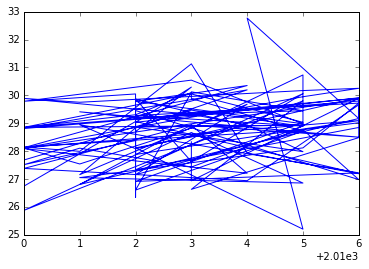

In [336]:
plt.plot()

In [326]:
%matplotlib inline